In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [181]:
df=pd.read_csv('AAPL.csv')
df.head()



,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-11-16,118.919998,120.989998,118.150002,120.300003,119.562920,91183000
1,2020-11-17,119.550003,120.669998,118.959999,119.389999,118.658493,74271000
2,2020-11-18,118.610001,119.820000,118.000000,118.029999,117.306831,76322100
3,2020-11-19,117.589996,119.059998,116.809998,118.639999,117.913086,74113000
4,2020-11-20,118.639999,118.769997,117.290001,117.339996,116.621056,73604300


In [182]:
#pip install pmdarima

In [183]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [184]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('AAPL.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-16,118.919998,120.989998,118.150002,120.300003,119.562920,91183000
2020-11-17,119.550003,120.669998,118.959999,119.389999,118.658493,74271000
2020-11-18,118.610001,119.820000,118.000000,118.029999,117.306831,76322100
2020-11-19,117.589996,119.059998,116.809998,118.639999,117.913086,74113000
2020-11-20,118.639999,118.769997,117.290001,117.339996,116.621056,73604300
...,...,...,...,...,...,...
2021-11-08,151.410004,151.570007,150.160004,150.440002,150.440002,55020900
2021-11-09,150.199997,151.429993,150.059998,150.809998,150.809998,56787900
2021-11-10,150.020004,150.130005,147.850006,147.919998,147.919998,65187100


## Visualize the stock’s daily closing price

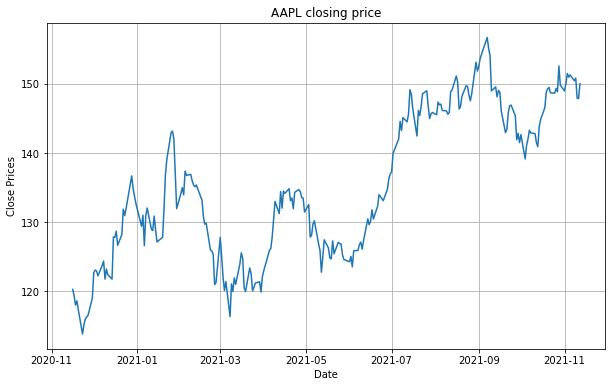

In [185]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('AAPL closing price')
plt.show()

## probability distribution to visualize the data in our series

<AxesSubplot:ylabel='Density'>

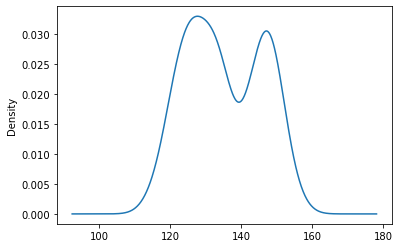

In [186]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

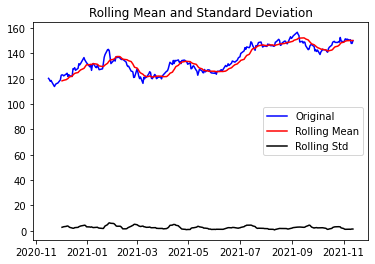

Results of dickey fuller test
Test Statistics                 -1.544322
p-value                          0.511483
No. of lags used                 0.000000
Number of observations used    250.000000
critical value (1%)             -3.456781
critical value (5%)             -2.873172
critical value (10%)            -2.572969
dtype: float64


In [187]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 432x288 with 0 Axes>

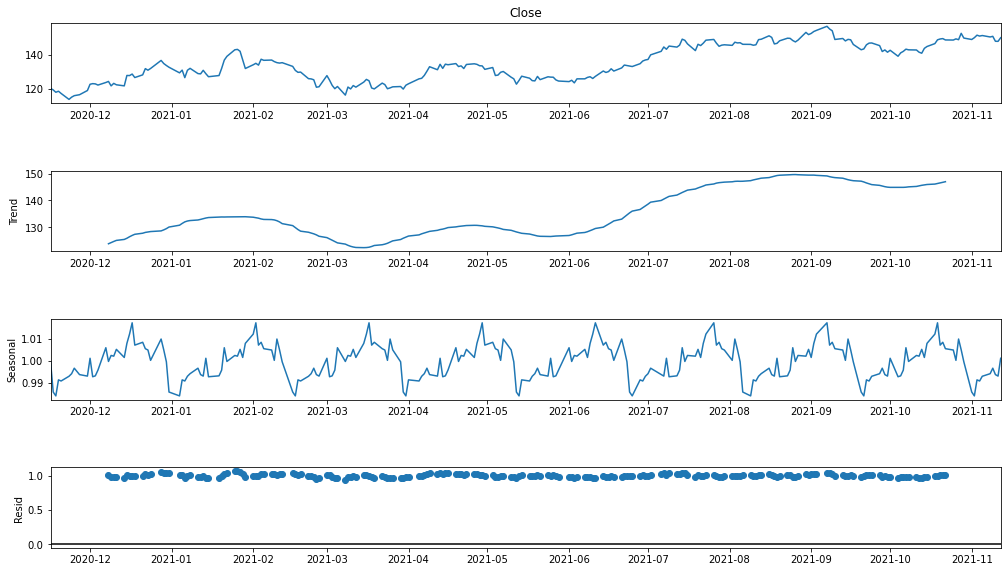

In [188]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


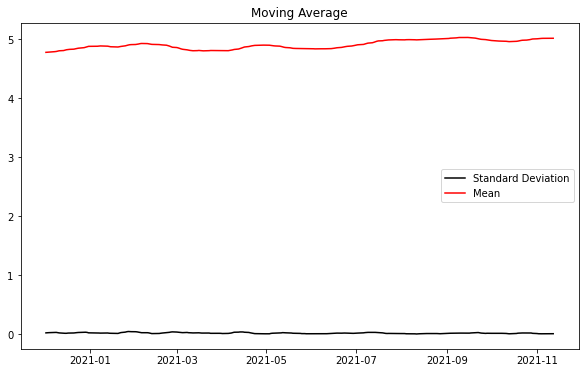

In [189]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

## visualize the data by dividing it into training and test sets

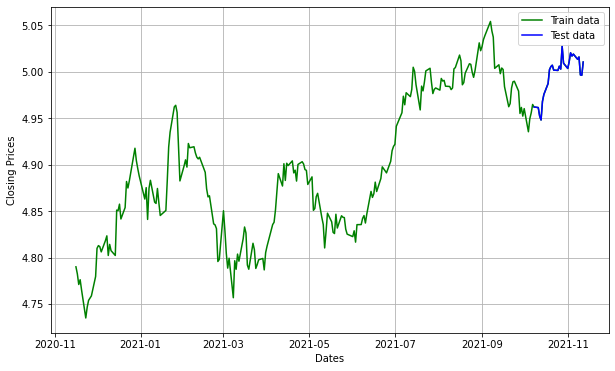

In [190]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

## Graphs 1.1

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1192.261, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1190.745, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1190.773, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1193.645, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1188.544, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.268 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  222
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 597.822
Date:                Tue, 16 Nov 2021   AIC                          -1193.645
Time:                        09:25:56   BIC                          -1190.246
Sample:                             0   HQIC                         -1192.272
                                - 222                                  

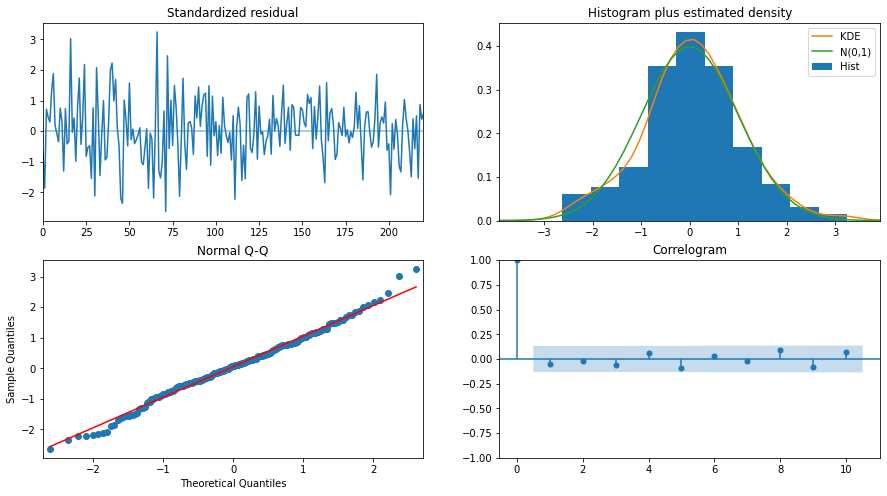

In [191]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [192]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(0,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  222
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 597.822
Date:                Tue, 16 Nov 2021   AIC                          -1193.645
Time:                        09:25:57   BIC                          -1190.246
Sample:                             0   HQIC                         -1192.272
                                - 222                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   2.26e-05     11.571      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                 1.63
Prob(Q):                              0.48   Pr

In [193]:
# Forecast
fc, se, conf = fitted.forecast(3, alpha=0.05)  # 95% conf

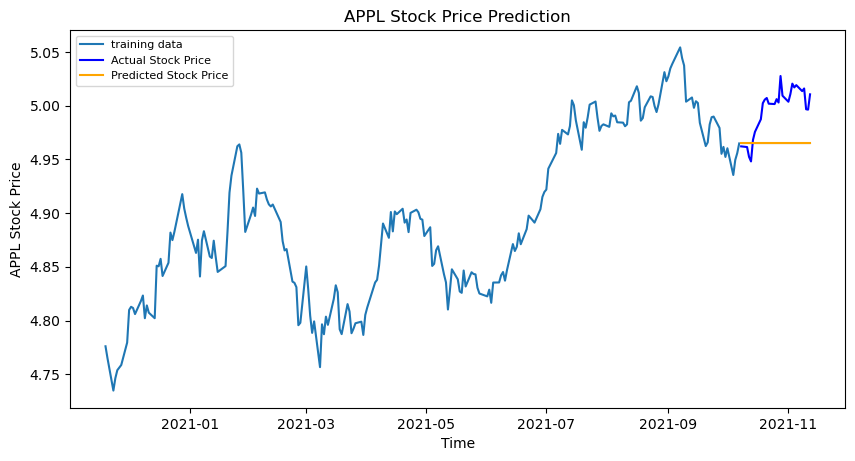

In [194]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
fc_series
lower_series = pd.Series(conf, index=test_data.index)
upper_series = pd.Series(conf, index=test_data.index)
# print(conf)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('APPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('APPL Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [195]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

TypeError: Expected sequence or array-like, got <class 'float'>